### Importamos las Librerias

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import sklearn.model_selection
import sklearn.metrics
from geopy.geocoders import Nominatim
from geopy import Location

c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [544]:
df = pd.read_csv('properties_colombia_train.csv')
df_org = df.copy()

#### Funcion para hacer consultas API para la conversion monetaria, es de paga y necesita un archivo keys.json que no se proveera al github para prevenir cargos de tarjeta por limite de consultas

In [3]:
def get_USD_to_COP(key,host):
    import requests

    url = "https://currency-converter5.p.rapidapi.com/currency/convert"

    querystring = {"format":"xml","from":"USD","to":"COP","amount":"1","language":"en"}

    headers = {
    	"X-RapidAPI-Key": key,
    	"X-RapidAPI-Host": host
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return float(response.text.split('Colombian peso')[1].split('<rate>')[1].split('</rate>')[0])
use_API = False
if use_API:
    import json
    keys = json.load(open('keys.json'))[0]
    USD_to_COP = get_USD_to_COP(keys['Key'],keys['Host'])
else:
    USD_to_COP = 4993.6281
print(USD_to_COP)

4993.6281


#### Conversion de USD a COP

In [4]:
mask = (df['currency'] == 'USD')
df.loc[mask,'price'] = df.loc[mask,'price']*USD_to_COP
df.loc[mask,'currency'] = 'COP'

In [5]:
df.isna().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

### Usamos un Geolocalizador para rellenar la longitud y latitud faltante en base a l1,l2 y l3

In [6]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [7]:
df.isna().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [8]:
df = df_org.copy()

In [9]:
df.isna().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [10]:
isna = pd.isna(df[['lat','lon','l1','l2','l3']])
isna



lat    lon     l1     l2     l3
0       False  False  False  False  False
1       False  False  False  False  False
2       False  False  False  False  False
3        True   True  False  False  False
4        True   True  False  False  False
...       ...    ...    ...    ...    ...
197544  False  False  False  False  False
197545  False  False  False  False  False
197546  False  False  False  False  False
197547  False  False  False  False  False
197548  False  False  False  False  False

[197549 rows x 5 columns]

### Creamos una mascara donde Longitud O Latitud sean nulos, pero l1,l2 y l3 no lo sean

In [11]:
mask = (isna['lat'] & isna['lon']) & ~isna['l1'] & ~isna['l2'] & ~isna['l3']
df[mask].index

Int64Index([     3,      4,      9,     11,     12,     15,     18,     19,
                23,     31,
            ...
            197504, 197511, 197515, 197520, 197526, 197532, 197533, 197537,
            197538, 197541],
           dtype='int64', length=49174)

### Creamos un Diccionario para que no se haga dos veces la misma consulta a la Api de Geolocalizacion

###### (Sin el diccionario puede crashear o tardar hasta media hora)

In [14]:
lat_lon_dicc = {}

In [15]:

for i in range(0,1):
    isna = pd.isna(df[['lat','lon','l1','l2','l3']])
    mask = (isna['lat'] | isna['lon']) & ~isna['l1'] & ~isna['l2'] & ~isna['l3']
    for index in df[mask].index:
        loc_str = df.at[index,'l1']+' '+df.at[index,'l2']+' '+df.at[index,'l3']
        if not (loc_str in lat_lon_dicc):
            location = [geolocator.geocode(loc_str).raw['lat'],geolocator.geocode(loc_str).raw['lon']]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            lat_lon_dicc[loc_str] = location
            print('[Not In Dicc] Location: ',location,' appended to Dicc')
        else:
            location = lat_lon_dicc[loc_str]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            print('[In Dicc] Location: ',location,' query avoided')

[Not In Dicc] Location:  ['7.1172633', '-73.1156668']  appended to Dicc
[Not In Dicc] Location:  ['6.2443382', '-75.573553']  appended to Dicc
[Not In Dicc] Location:  ['10.9810761', '-74.7988827']  appended to Dicc
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[Not In Dicc] Location:  ['8.6046053', '-75.97832027208273']  appended to Dicc
[Not In Dicc] Location:  ['4.8272214', '-74.0310254']  appended to Dicc
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[Not In Dicc] Location:  ['4.1315113', '-73.6206667']  appended to Dicc
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[Not In Dicc] Location:  ['4.7465494', '-75.9121234']  appended to Dicc
[In Dicc] Location:  ['6.2443382', '-75.5

In [16]:
df.isna().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                   324
lon                   324
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

### Hacemos lo mismo pero con una mascara donde Latitud O Longitud sea nulo, l1 y l2 no sean nulos y l3 sea nulo

In [17]:
isna = pd.isna(df[['lat','lon','l1','l2','l3']])
mask = (isna['lat'] | isna['lon']) & ~isna['l1'] & ~isna['l2'] & isna['l3']

In [18]:
for i in range(0,1):
    isna = pd.isna(df[['lat','lon','l1','l2','l3']])
    mask = (isna['lat'] | isna['lon']) & ~isna['l1'] & ~isna['l2'] & isna['l3']
    for index in df[mask].index:
        loc_str = df.at[index,'l1']+' '+df.at[index,'l2']
        if not (loc_str in lat_lon_dicc):
            location = [geolocator.geocode(loc_str).raw['lat'],geolocator.geocode(loc_str).raw['lon']]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            lat_lon_dicc[loc_str] = location
            print('[Not In Dicc] Location: ',location,' appended to Dicc')
        else:
            location = lat_lon_dicc[loc_str]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            print('[In Dicc] Location: ',location,' query avoided')

[Not In Dicc] Location:  ['7.0000085', '-75.5000086']  appended to Dicc
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[Not In Dicc] Location:  ['9', '-75']  appended to Dicc
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.00

In [19]:
df['l3'].fillna('Otro',inplace=True)
df['l4'].fillna('Otro',inplace=True)
df['l5'].fillna('Otro',inplace=True)
df.isna().sum()


Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                      0
l5                      0
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

#### Normalizacion

### Creamos una columna numerica para los años, meses y dia y de las 3 columnas con fechas

In [20]:
from datetime import datetime
df['start_year'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['start_month'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['start_day'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))
df['end_year'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['end_month'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['end_day'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))
df['created_year'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['created_month'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['created_day'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))


#### Extraer Bedrooms, Rooms y Bathrooms de la columna description mediante RegEx

In [21]:
def create_regex(words):
    output = ''
    for word in words:
        for index in range(0,len(word)):
            word_list = list(word)
            word_list.pop(index)
            output += '{}|'.format((''.join(word_list)))

    return '({})'.format(output[:-1]).replace('a','(á|a)').replace('e','(é|e)').replace('i','(í|i)').replace('o','(ó|o)').replace('u','(ú|u)').replace('n','(ñ|n)').replace('ñ','(ñ|n)')
def find_bedrooms(text):
    bedrooms = re.findall("([1-9]? {})".format(create_regex(['habitacion','alcoba','dormitorio','cuarto'])), text,flags=re.I)
    bedrooms = [bedroom[0] for bedroom in bedrooms]
    bedrooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in bedroom if i.isdigit()) for bedroom in bedrooms]]
    bedrooms = sum(bedrooms)
    return bedrooms
def find_rooms(text):
    rooms = re.findall("([1-9]? {})".format(create_regex(['cocina','parqueadero','sala','comedor','comedor'])), text,flags=re.I)
    rooms = [room[0] for room in rooms]
    rooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in room if i.isdigit()) for room in rooms]]
    rooms = sum(rooms)
    return rooms
def find_bathrooms(text):
    bathrooms = re.findall("([1-9]? {})".format(create_regex(['baño'])), txt,flags=re.I)
    bathrooms = [bathroom[0] for bathroom in bathrooms]
    bathrooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in bathroom if i.isdigit()) for bathroom in bathrooms]]
    bathrooms = sum(bathrooms)
    return bathrooms

##### Demostracion

In [22]:
import re
txt = '''Apartamento en barrio Bella vista. Cuenta con 3 habitaciones ,2 alcobas , dormitorio,sala comedor, cocina, 9 baños, área de labores y terraza. Este inmueble tiene 340M2.
|Asesor GISSELL CORRO|
Oficina ubicada en la Calle 76 #51B- 28 Local 3
(IMAGEN SOLO DE REFERENCIA)'''

bedrooms = re.findall("([1-9]? {})".format(create_regex(['habitacion','alcoba','dormitorio','cuarto'])), txt,flags=re.I)
bedrooms = [bedroom[0] for bedroom in bedrooms]
bedrooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in bedroom if i.isdigit()) for bedroom in bedrooms]]
bedrooms = sum(bedrooms)

rooms = re.findall("([1-9]? {})".format(create_regex(['cocina','parqueadero','sala','comedor','comedor'])), txt,flags=re.I)
rooms = [room[0] for room in rooms]
rooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in room if i.isdigit()) for room in rooms]]
rooms = sum(rooms)

bathrooms = re.findall("([1-9]? {})".format(create_regex(['baño'])), txt,flags=re.I)
bathrooms = [bathroom[0] for bathroom in bathrooms]
bathrooms = [int(s.replace('','1')) if s == '' else int(s) for s in [''.join(i for i in bathroom if i.isdigit()) for bathroom in bathrooms]]
bathrooms = sum(bathrooms)

print(bedrooms)
print(rooms)
print(bathrooms)

6
2
9


### Extraemos del dataframe para rellenar faltantes

In [23]:
mask = pd.isna(df['bedrooms'])
df.loc[mask,'bedrooms'] = df.loc[mask,'description'].apply(lambda x: int(find_bedrooms(x)) if isinstance(x,str) else int(df['bedrooms'].mean()))
mask = pd.isna(df['bathrooms'])
df.loc[mask,'bathrooms'] = df.loc[mask,'description'].apply(lambda x: int(find_bathrooms(x)) if isinstance(x,str) else int(df['bathrooms'].mean()))
mask = pd.isna(df['rooms'])
df.loc[mask,'rooms'] = df.loc[mask,'description'].apply(lambda x: int(find_rooms(x)) if isinstance(x,str) else int(df['rooms'].mean()))

In [24]:
df['property_type'].fillna(df['property_type'].mode(),inplace=True)
df['surface_covered'].fillna(df['surface_covered'].mean(), inplace=True)
df.drop(df[pd.isna(df['price'])].index,inplace=True)
df.isna().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                      0
l5                      0
l6                 190636
rooms                   0
bedrooms                0
bathrooms               0
surface_total      190544
surface_covered         0
price                   0
currency                4
price_period       161515
title                   1
description           121
property_type           0
operation_type          0
geometry                0
start_year              0
start_month             0
start_day               0
end_year                0
end_month               0
end_day                 0
created_year            0
created_month           0
created_day             0
dtype: int64

### Dropeamos las columnas que no utilizaremos

In [25]:
df.drop(columns=['Unnamed: 0','id','ad_type','start_date','l1','end_date','created_on','l6','surface_total','currency','price_period','title','description','operation_type'],inplace=True)

In [26]:
df.drop(columns=['geometry'],inplace=True)

In [27]:
df.isna().sum()

lat                0
lon                0
l2                 0
l3                 0
l4                 0
l5                 0
rooms              0
bedrooms           0
bathrooms          0
surface_covered    0
price              0
property_type      0
start_year         0
start_month        0
start_day          0
end_year           0
end_month          0
end_day            0
created_year       0
created_month      0
created_day        0
dtype: int64

In [28]:
df.dtypes

lat                 object
lon                 object
l2                  object
l3                  object
l4                  object
l5                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_covered    float64
price              float64
property_type       object
start_year           int64
start_month          int64
start_day            int64
end_year             int64
end_month            int64
end_day              int64
created_year         int64
created_month        int64
created_day          int64
dtype: object

In [29]:
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)
df['l2'] = df['l2'].astype(str)
df['l3'] = df['l3'].astype(str)
df['l4'] = df['l4'].astype(str)
df['l5'] = df['l5'].astype(str)
df['rooms'] = df['rooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['property_type'] = df['property_type'].astype(str)


In [30]:
df.dtypes 


lat                float64
lon                float64
l2                  object
l3                  object
l4                  object
l5                  object
rooms                int32
bedrooms             int32
bathrooms            int32
surface_covered    float64
price              float64
property_type       object
start_year           int64
start_month          int64
start_day            int64
end_year             int64
end_month            int64
end_day              int64
created_year         int64
created_month        int64
created_day          int64
dtype: object

### Frequency encoding, desestimado por tener peor performance que LabelEncoder

In [ ]:
#for column in ['l2','l3','l4','l5','property_type']:
#    freq = df.groupby(column).size() / len(df)
#    df[column] = df[column].apply(lambda x: freq[x])


### One Hot Encoding, tambien desestimado por la dimensionalidad resultante

In [31]:
#dummies = pd.get_dummies(df)

In [32]:
df_norm = df.copy()

In [482]:
df = df_norm.copy()

### Label encoder utilizado

In [483]:
le = LabelEncoder()
for column in ['l2','l3','l4','l5','property_type']:
    df[column] = le.fit_transform(df[column].values)


In [484]:
df.dtypes


lat                float64
lon                float64
l2                   int32
l3                   int32
l4                   int32
l5                   int32
rooms                int32
bedrooms             int32
bathrooms            int32
surface_covered    float64
price              float64
property_type        int32
start_year           int64
start_month          int64
start_day            int64
end_year             int64
end_month            int64
end_day              int64
created_year         int64
created_month        int64
created_day          int64
dtype: object

In [485]:
df

lat        lon  l2   l3  l4  l5  rooms  bedrooms  bathrooms  \
0        6.203000 -75.572000   1  148  15  10      0         4          4   
1        4.722748 -74.073115  12   27  54  15      5         3          2   
2        4.709000 -74.030000  12   27  55  19      4         2          2   
3        7.117263 -73.115667  26   29  30  10      0         0          1   
4        6.244338 -75.573553   1  148  30  10      5         3          2   
...           ...        ...  ..  ...  ..  ..    ...       ...        ...   
197544   4.649682 -74.161950  12   27  58   7      3         3          9   
197545   4.668000 -74.055000  12   27  53   3      1         0          1   
197546   3.413000 -76.541000  29   38  30  10      3         0          1   
197547   4.674874 -74.147077  12   27  56   6      0         0          2   
197548  10.935994 -74.802899   3   24  30  10      2         0          1   

        surface_covered  ...  property_type  start_year  start_month  \
0            948.335646  ...              1        2020           12   
1            948.335646  ...              0        2020            9   
2            948.335646  ...              1        2020            8   
3            948.335646  ...              6        2020           11   
4            948.335646  ...              0        2020           10   
...                 ...  ...            ...         ...          ...   
197544       948.335646  ...              0        2020           10   
197545        17.000000  ...              5        2020           11   
197546       948.335646  ...              6        2020           10   
197547       948.335646  ...              1        2020            8   
197548       948.335646  ...              0        2020           10   

        start_day  end_year  end_month  end_day  created_year  created_month  \
0              14      9999         12       31          2020             12   
1              16      2021          5       14          2020              9   
2              19      2020          8       20          2020              8   
3              23      2020         11       30          2020             11   
4               6      2020         10        7          2020             10   
...           ...       ...        ...      ...           ...            ...   
197544         27      9999         12       31          2020             10   
197545         27      2020         12        9          2020             11   
197546         28      2021          1        2          2020             10   
197547         14      2020          8       14          2020              8   
197548          6      2020         11       27          2020             10   

        created_day  
0                14  
1                16  
2                19  
3                23  
4                 6  
...             ...  
197544           27  
197545           27  
197546           28  
197547           14  
197548            6  

[197486 rows x 21 columns]

##### Creamos el Encoder y la Columna Target

In [486]:
#0 = Barato, 1= Caro
price_mean = round(df['price'].mean(), 2)
df['target'] = 0
mask = (df['price'] <= price_mean)
df.loc[mask,'target'] = 0
mask = (df['price'] > price_mean)
df.loc[mask,'target'] = 1

In [487]:
df['target'].value_counts()

0    151128
1     46358
Name: target, dtype: int64

In [488]:
df.drop(columns=['price'],inplace=True)

In [489]:
df.columns

Index(['lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'rooms', 'bedrooms', 'bathrooms',
       'surface_covered', 'property_type', 'start_year', 'start_month',
       'start_day', 'end_year', 'end_month', 'end_day', 'created_year',
       'created_month', 'created_day', 'target'],
      dtype='object')

In [490]:
df

lat        lon  l2   l3  l4  l5  rooms  bedrooms  bathrooms  \
0        6.203000 -75.572000   1  148  15  10      0         4          4   
1        4.722748 -74.073115  12   27  54  15      5         3          2   
2        4.709000 -74.030000  12   27  55  19      4         2          2   
3        7.117263 -73.115667  26   29  30  10      0         0          1   
4        6.244338 -75.573553   1  148  30  10      5         3          2   
...           ...        ...  ..  ...  ..  ..    ...       ...        ...   
197544   4.649682 -74.161950  12   27  58   7      3         3          9   
197545   4.668000 -74.055000  12   27  53   3      1         0          1   
197546   3.413000 -76.541000  29   38  30  10      3         0          1   
197547   4.674874 -74.147077  12   27  56   6      0         0          2   
197548  10.935994 -74.802899   3   24  30  10      2         0          1   

        surface_covered  ...  start_year  start_month  start_day  end_year  \
0            948.335646  ...        2020           12         14      9999   
1            948.335646  ...        2020            9         16      2021   
2            948.335646  ...        2020            8         19      2020   
3            948.335646  ...        2020           11         23      2020   
4            948.335646  ...        2020           10          6      2020   
...                 ...  ...         ...          ...        ...       ...   
197544       948.335646  ...        2020           10         27      9999   
197545        17.000000  ...        2020           11         27      2020   
197546       948.335646  ...        2020           10         28      2021   
197547       948.335646  ...        2020            8         14      2020   
197548       948.335646  ...        2020           10          6      2020   

        end_month  end_day  created_year  created_month  created_day  target  
0              12       31          2020             12           14       1  
1               5       14          2020              9           16       0  
2               8       20          2020              8           19       0  
3              11       30          2020             11           23       1  
4              10        7          2020             10            6       0  
...           ...      ...           ...            ...          ...     ...  
197544         12       31          2020             10           27       0  
197545         12        9          2020             11           27       0  
197546          1        2          2020             10           28       0  
197547          8       14          2020              8           14       0  
197548         11       27          2020             10            6       0  

[197486 rows x 21 columns]

### Modelo de Random Forest

In [491]:
X = df[[column for column in df.columns if column in ['l4','l5','bedrooms','bathrooms','property_type']]].values
y = df[[column for column in df.columns if column =='target']].values.ravel()

In [75]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 70, num = 10)]
max_features = ['log2']
max_depth = [int(x) for x in np.linspace(100, 140, num = 10)]
max_depth.append(None)
min_samples_split = [2,3,4]
min_samples_leaf = [int(x) for x in np.linspace(8, 15, num = 5)]
bootstrap = [False]

random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap}
pprint(random_grid)

{'randomforestclassifier__bootstrap': [False],
 'randomforestclassifier__max_depth': [100,
                                       104,
                                       108,
                                       113,
                                       117,
                                       122,
                                       126,
                                       131,
                                       135,
                                       140,
                                       None],
 'randomforestclassifier__max_features': ['log2'],
 'randomforestclassifier__min_samples_leaf': [8, 9, 11, 13, 15],
 'randomforestclassifier__min_samples_split': [2, 3, 4],
 'randomforestclassifier__n_estimators': [30,
                                          34,
                                          38,
                                          43,
                                          47,
                                          52,
                  

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
rf = RandomForestClassifier()
rf = make_pipeline(MinMaxScaler(),rf)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1, scoring=recall_score)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [False],
                                        'randomforestclassifier__max_depth': [100,
                                                                              104,
                                                                              108,
                                                                              113,
                                                                              117,
                                                                              122,
                                                                              126,
                                                                              131,
                                                                              135,
                                                                              140,
                                                                              None],
                                        'randomforestclassifier__max_features': ['log2'],
                                        'randomforestclassifier__min_samples_leaf': [8,
                                                                                     9,
                                                                                     11,
                                                                                     13,
                                                                                     15],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      3,
                                                                                      4],
                                        'randomforestclassifier__n_estimators': [30,
                                                                                 34,
                                                                                 38,
                                                                                 43,
                                                                                 47,
                                                                                 52,
                                                                                 56,
                                                                                 61,
                                                                                 65,
                                                                                 70]},
                   random_state=42,
                   scoring=<function recall_score at 0x0000014B30612CB0>,
                   verbose=2)

In [77]:
rf_random.best_estimator_

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=131,
                                        max_features='log2',
                                        min_samples_leaf=11,
                                        min_samples_split=3,
                                        n_estimators=56))])

In [78]:
y_pred = rf_random.best_estimator_.predict(X_test)
print('recall: ',recall_score(y_test,y_pred))
print('accuracy: ',recall_score(y_test,y_pred,average='weighted'))

recall:  0.5320243505101603
accuracy:  0.8414080855545654


### Modelo de ExtraTreesClassifier

In [ ]:
#Sacrificio de Accuracy por recall, hacemos undersampling a las filas con target 0
for index in df.index:
    if df.loc[index,'target'] == 0 and np.random.randint(1,2) == 2:
        df.at[index,'target'] = 2

In [503]:
df2 = df[df['target'].isin([0,1])]
df2['target'].value_counts()

1    46358
0    12033
Name: target, dtype: int64

In [504]:
X = df2[[column for column in df.columns if column !='target']].values
y = df2[[column for column in df.columns if column =='target']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

recall:  0.9658972578965637
accuracy:  0.906288532675709


c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


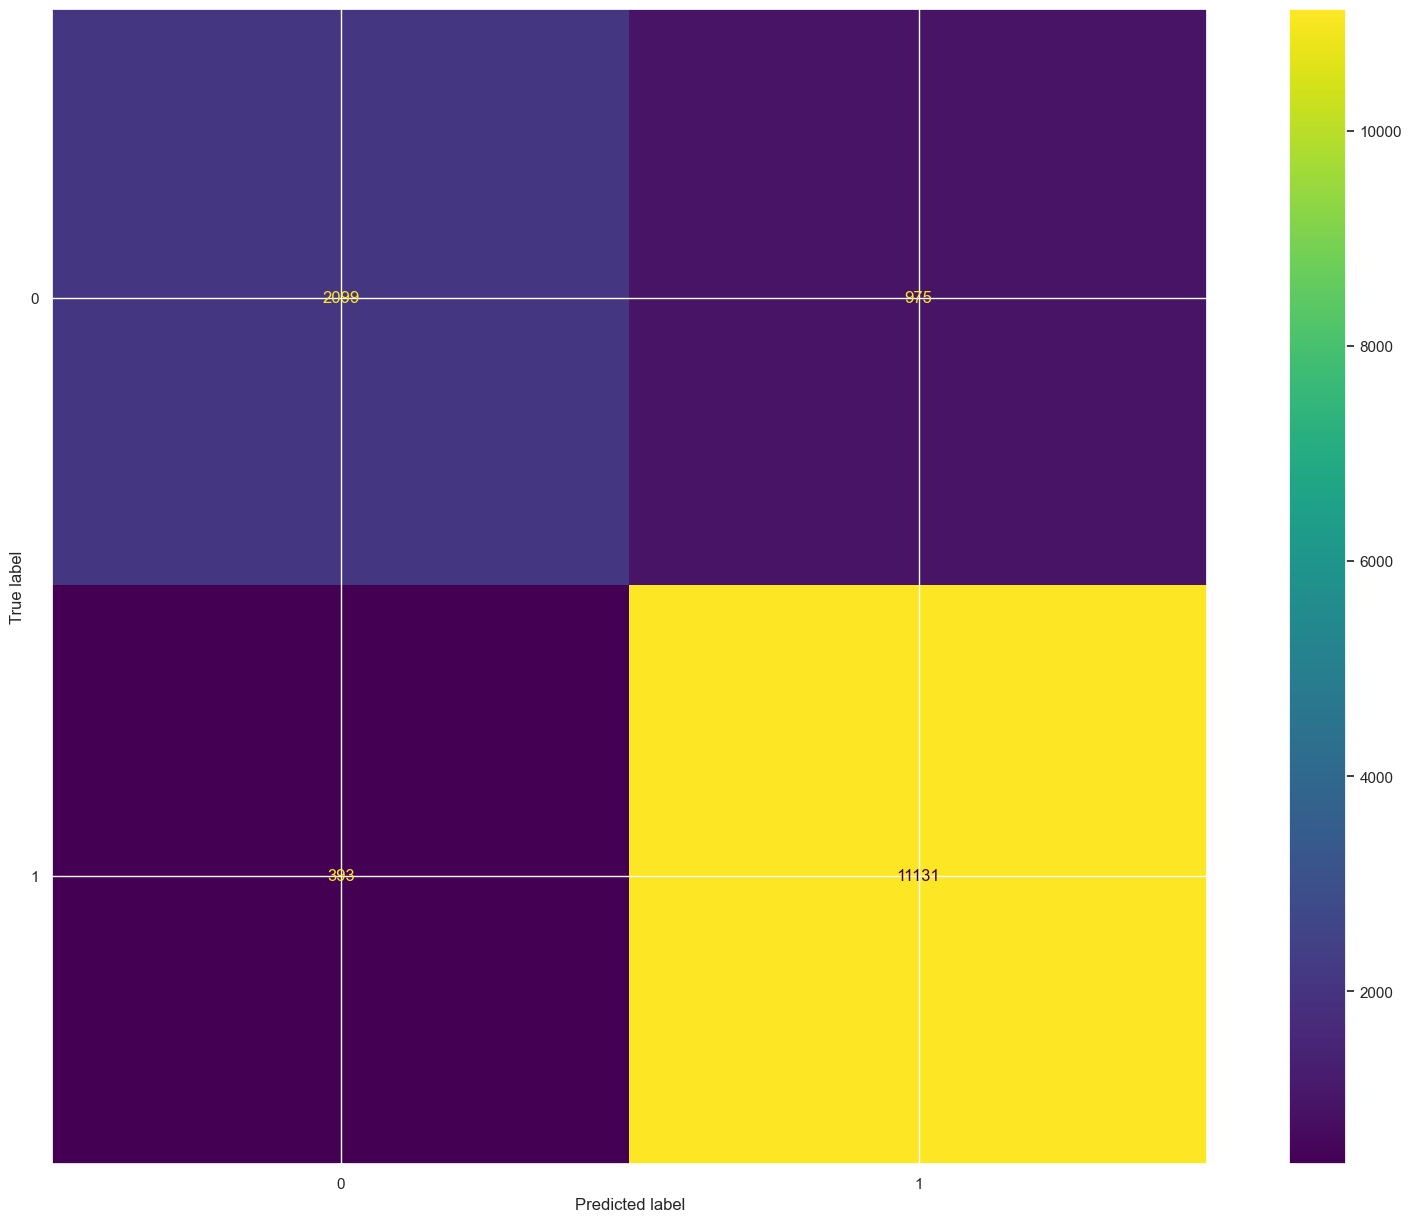

In [505]:
from sklearn.preprocessing import MaxAbsScaler
etc_model = ExtraTreesClassifier(max_features=20, min_samples_leaf=1, min_samples_split=2,
                       n_estimators=512, n_jobs=2,
                       warm_start=True,criterion='entropy')
etc_model = make_pipeline(MaxAbsScaler(),etc_model)
etc_model.fit(X_train,y_train)
y_pred = etc_model.predict(X_test)
print('recall: ',recall_score(y_test,y_pred))
print('accuracy: ',recall_score(y_test,y_pred,average='weighted'))
plot_confusion_matrix(etc_model, X_test, y_test)

### Modelo de Gradient Boosting por Histogramas

In [117]:
from sklearn.preprocessing import MinMaxScaler
X = df[[column for column in df.columns if column !='target']].values
y = df[[column for column in df.columns if column =='target']].values.ravel()

recall:  0.7643562938565087
accuracy:  0.9024913074300375


c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


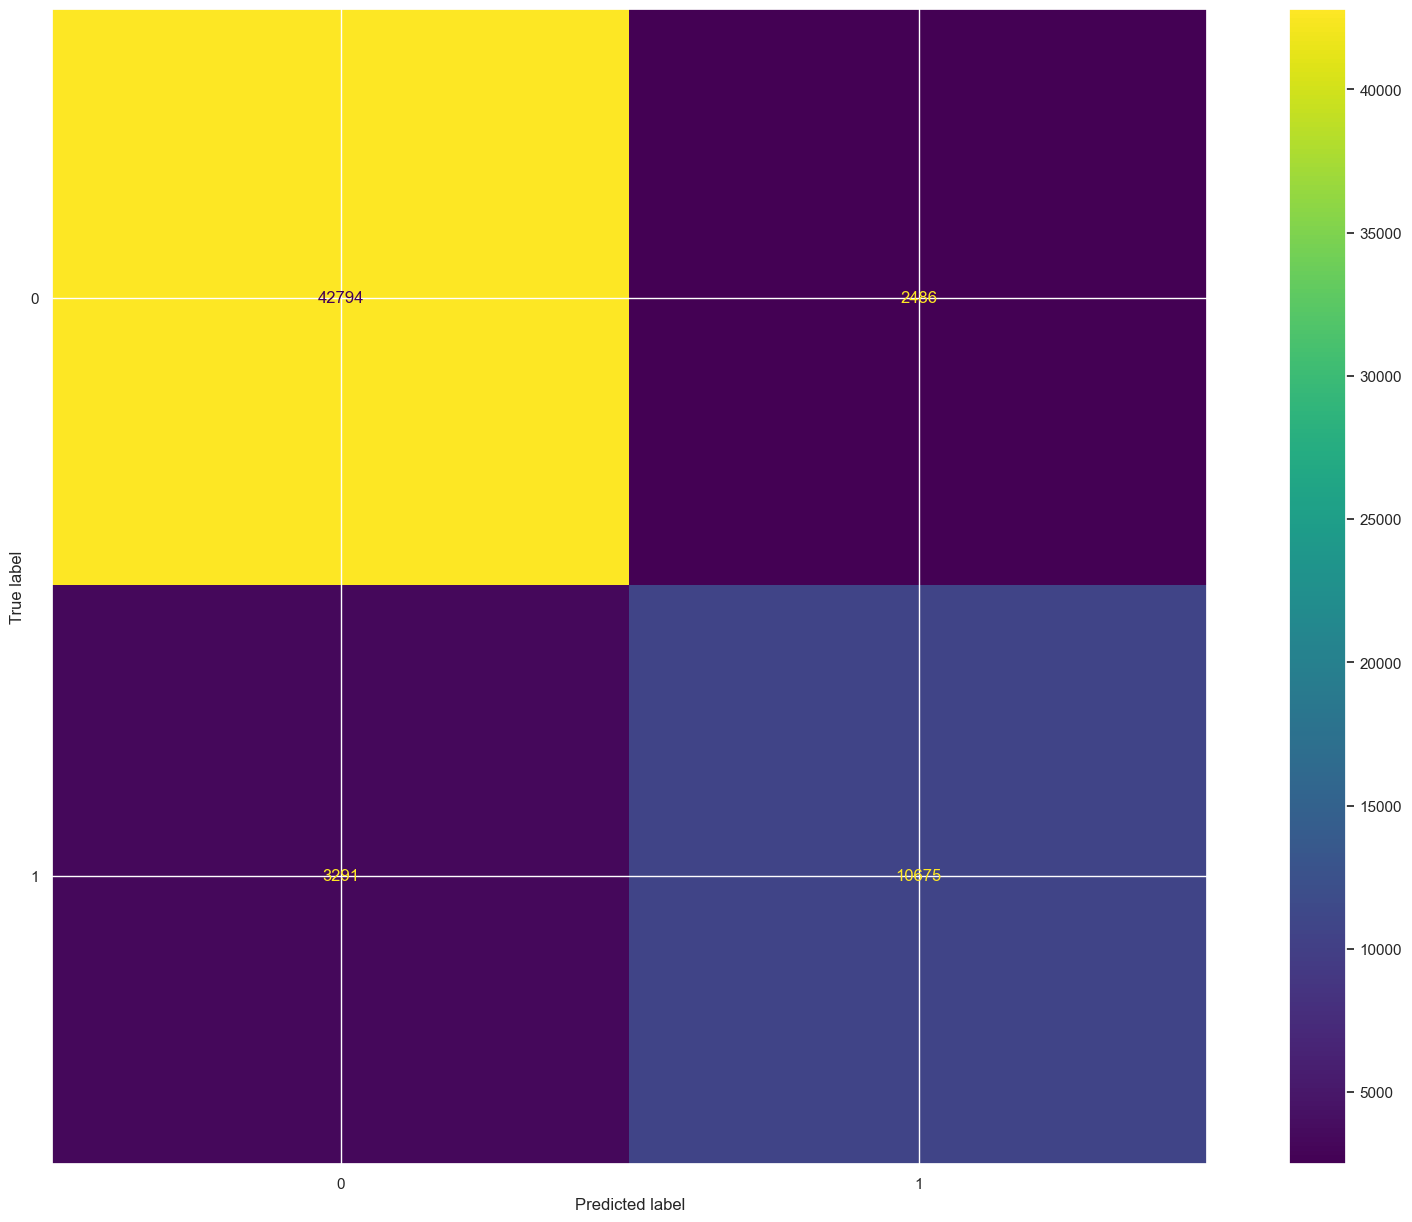

In [150]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)
hgb_model = HistGradientBoostingClassifier(early_stopping=True,
                                 learning_rate=0.27, max_iter=1024,
                                 max_leaf_nodes=512, min_samples_leaf=26,
                                 n_iter_no_change=16,
                                 validation_fraction=None, warm_start=True)
hgb_model = make_pipeline(MaxAbsScaler(),hgb_model)
hgb_model.fit(X_train,y_train)
y_pred = hgb_model.predict(X_test)
print('recall: ',recall_score(y_test,y_pred))
print('accuracy: ',recall_score(y_test,y_pred,average='weighted'))
plot_confusion_matrix(hgb_model, X_test, y_test)


### Modelos LinearSVC

In [63]:
X = df[[column for column in df.columns if column !='target']].values
y = df[[column for column in df.columns if column =='target']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)

In [321]:
comp_list = []
acc_list = []
recall_list = []
c_list = []
intercept_list = []
for n_component in [4]:
    for C_value in [30]:
        for intercept_value in np.arange(0.05,0.21,0.005):
            clf = LinearSVC(C=C_value, class_weight='balanced', dual=False,
                        intercept_scaling=intercept_value, tol=0.5)
            clf = make_pipeline(MinMaxScaler(),clf)
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            Recall = tp/(tp+fn)
            comp_list.append(n_component)
            recall_list.append(Recall)
            c_list.append(C_value)
            intercept_list.append(intercept_value)
            acc_list.append(recall_score(y_test,y_pred,average='weighted'))


In [ ]:
pd.DataFrame([comp_list,c_list,intercept_list,recall_list,acc_list]).T.rename(columns={
    0:'n_components',
    1:'C_Value',
    2:'intercept_Value',
    3:'recall_score',
    4:'accuracy'}).sort_values(by=['recall_score',]).to_excel('recall_svc.xlsx')

recall:  0.5929006259110006
accuracy:  0.7320140970590618


c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


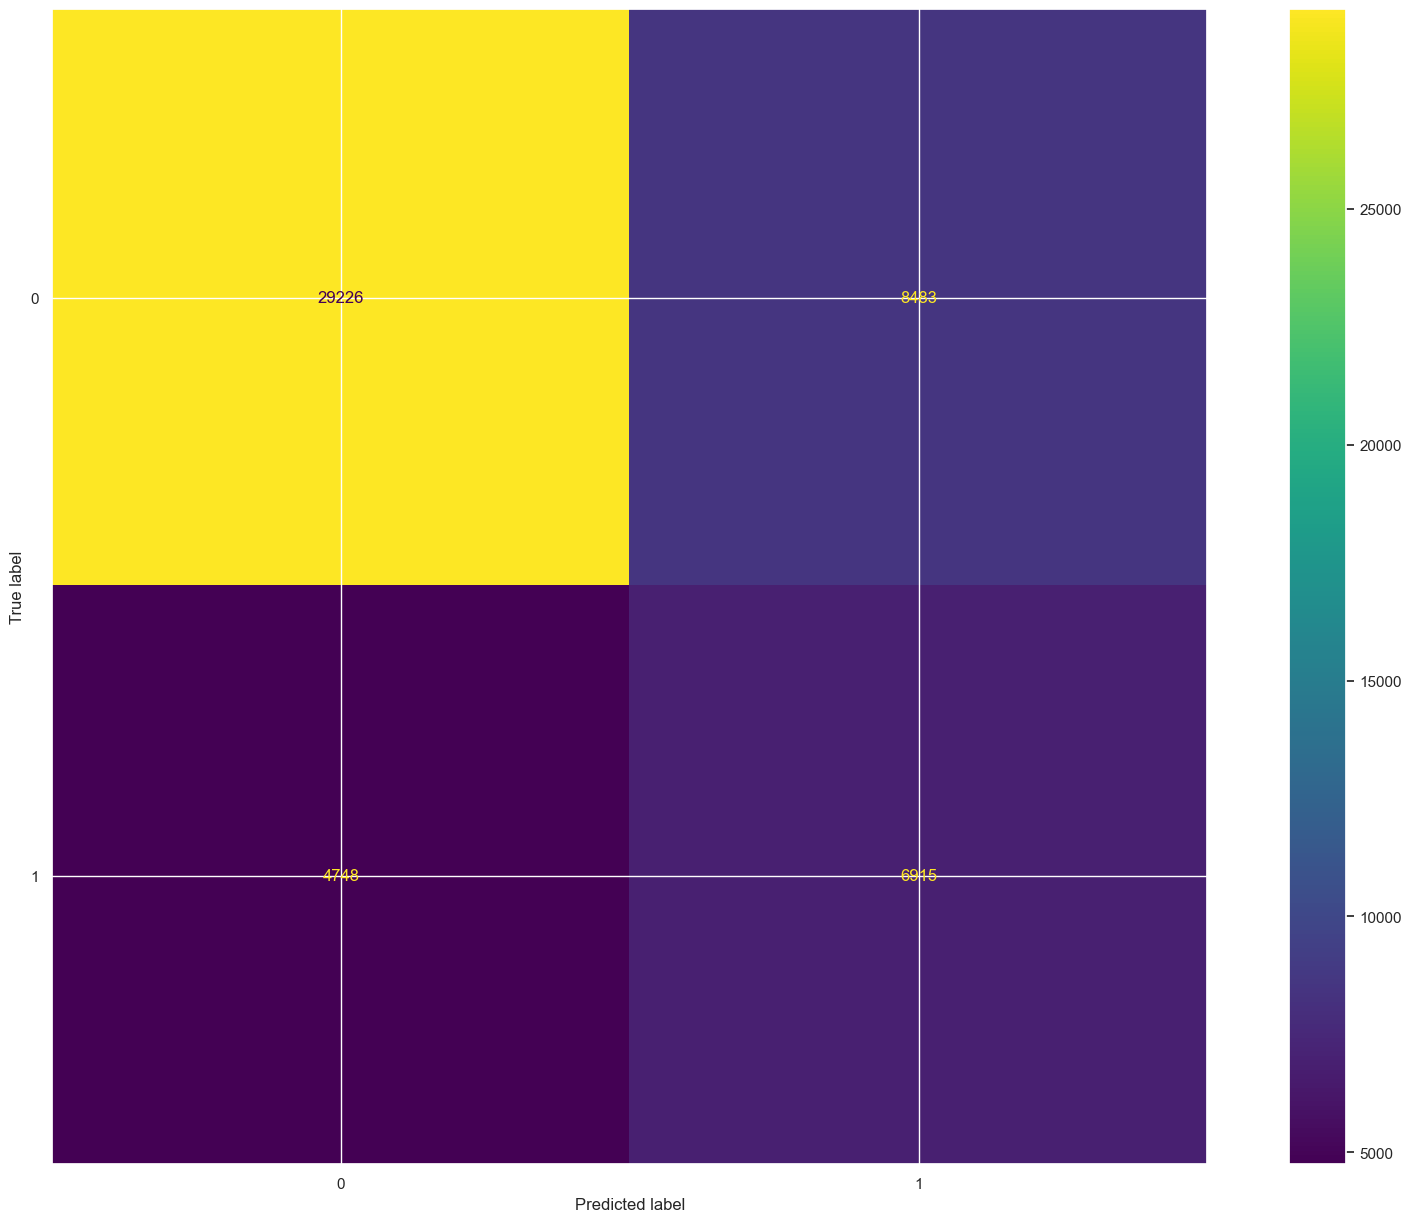

In [64]:
lsvc_model = LinearSVC(C=50, class_weight='balanced', dual=False,
                intercept_scaling=0.14, tol=0.5)
lsvc_model = make_pipeline(MinMaxScaler(),lsvc_model)
lsvc_model.fit(X_train,y_train)
y_pred = lsvc_model.predict(X_test)
print('recall: ',recall_score(y_test,y_pred))
print('accuracy: ',recall_score(y_test,y_pred,average='weighted'))
plot_confusion_matrix(lsvc_model, X_test, y_test)

In [323]:
X = df[[column for column in df.columns if column !='target']].values
y = df[[column for column in df.columns if column =='target']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

recall:  0.6045493685419059
accuracy:  0.6038382338048138


c:\Users\codek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


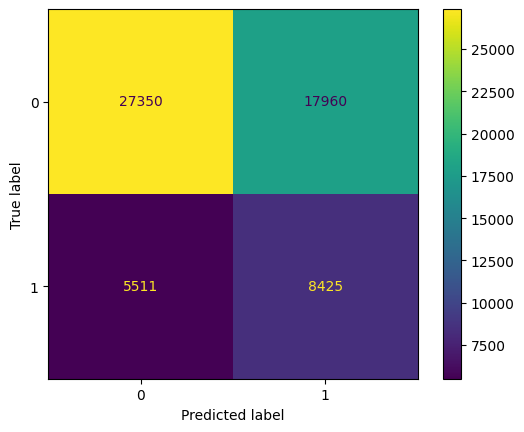

In [324]:
lsvc_model2 = LinearSVC(C=50, class_weight='balanced', dual=False,
                intercept_scaling=0.14, tol=0.5)
lsvc_model2 = make_pipeline(StandardScaler(),PCA(n_components=3),lsvc_model2)
lsvc_model2.fit(X_train,y_train)
y_pred = lsvc_model2.predict(X_test)
print('recall: ',recall_score(y_test,y_pred))
print('accuracy: ',recall_score(y_test,y_pred,average='weighted'))
plot_confusion_matrix(lsvc_model2, X_test, y_test)

### Aplicamos la misma Normalizacion al set de Pruebas y predecimos

In [506]:
df = pd.read_csv('properties_colombia_test.csv')

In [507]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [508]:
for i in range(0,1):
    isna = pd.isna(df[['lat','lon','l1','l2','l3']])
    mask = (isna['lat'] | isna['lon']) & ~isna['l1'] & ~isna['l2'] & ~isna['l3']
    for index in df[mask].index:
        loc_str = df.at[index,'l1']+' '+df.at[index,'l2']+' '+df.at[index,'l3']
        if not (loc_str in lat_lon_dicc):
            location = [geolocator.geocode(loc_str).raw['lat'],geolocator.geocode(loc_str).raw['lon']]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            lat_lon_dicc[loc_str] = location
            print('[Not In Dicc] Location: ',location,' appended to Dicc')
        else:
            location = lat_lon_dicc[loc_str]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            print('[In Dicc] Location: ',location,' query avoided')

[In Dicc] Location:  ['6.1701348', '-75.587415']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['-4.2129211', '-69.9425963']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.1701348', '-75.587415']  query avoided
[In Dicc] Location:  ['4.8142838', '-75.6946671']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-75.573553']  query avoided
[In Dicc] Location:  ['6.2443382', '-

In [509]:
for i in range(0,1):
    isna = pd.isna(df[['lat','lon','l1','l2','l3']])
    mask = (isna['lat'] | isna['lon']) & ~isna['l1'] & ~isna['l2'] & isna['l3']
    for index in df[mask].index:
        loc_str = df.at[index,'l1']+' '+df.at[index,'l2']
        if not (loc_str in lat_lon_dicc):
            location = [geolocator.geocode(loc_str).raw['lat'],geolocator.geocode(loc_str).raw['lon']]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            lat_lon_dicc[loc_str] = location
            print('[Not In Dicc] Location: ',location,' appended to Dicc')
        else:
            location = lat_lon_dicc[loc_str]
            df.at[index,'lat'] = location[0]
            df.at[index,'lon'] = location[1]
            print('[In Dicc] Location: ',location,' query avoided')

[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['2.5000086', '-69.0000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['7.0000085', '-75.5000086']  query avoided
[In Dicc] Location:  ['5.

In [510]:
df['l3'].fillna('Otro',inplace=True)
df['l4'].fillna('Otro',inplace=True)
df['l5'].fillna('Otro',inplace=True)
df.isna().sum()


Unnamed: 0             0
id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                    0
lon                    0
l1                     0
l2                     0
l3                     0
l4                     0
l5                     0
l6                 63486
rooms              56740
bedrooms           52447
bathrooms          13796
surface_total      63536
surface_covered    62545
currency              17
price_period       53729
title                  0
description           27
property_type          0
operation_type         0
geometry               0
dtype: int64

#### Normalizacion

In [511]:
from datetime import datetime
#Creamos una columna numerica para los años, meses y dia y de las 3 columnas con fechas
df['start_year'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['start_month'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['start_day'] = df['start_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))
df['end_year'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['end_month'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['end_day'] = df['end_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))
df['created_year'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.year))
df['created_month'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.month))
df['created_day'] = df['created_on'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).apply(lambda x: int(x.day))


In [512]:
mask = pd.isna(df['bedrooms'])
df.loc[mask,'bedrooms'] = df.loc[mask,'description'].apply(lambda x: int(find_bedrooms(x)) if isinstance(x,str) else int(3))
mask = pd.isna(df['bathrooms'])
df.loc[mask,'bathrooms'] = df.loc[mask,'description'].apply(lambda x: int(find_bathrooms(x)) if isinstance(x,str) else int(3))
mask = pd.isna(df['rooms'])
df.loc[mask,'rooms'] = df.loc[mask,'description'].apply(lambda x: int(find_rooms(x)) if isinstance(x,str) else int(4))

In [513]:
df['property_type'].fillna(df['property_type'].mode(),inplace=True)
df['surface_covered'].fillna(df['surface_covered'].mean(), inplace=True)
df.isna().sum()

Unnamed: 0             0
id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                    0
lon                    0
l1                     0
l2                     0
l3                     0
l4                     0
l5                     0
l6                 63486
rooms                  0
bedrooms               0
bathrooms              0
surface_total      63536
surface_covered        0
currency              17
price_period       53729
title                  0
description           27
property_type          0
operation_type         0
geometry               0
start_year             0
start_month            0
start_day              0
end_year               0
end_month              0
end_day                0
created_year           0
created_month          0
created_day            0
dtype: int64

In [514]:
df.drop(columns=['Unnamed: 0','geometry','id','ad_type','start_date','l1','end_date','created_on','l6','surface_total','currency','price_period','title','description','operation_type'],inplace=True)

In [515]:
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)
df['l2'] = df['l2'].astype(str)
df['l3'] = df['l3'].astype(str)
df['l4'] = df['l4'].astype(str)
df['l5'] = df['l5'].astype(str)
df['rooms'] = df['rooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['property_type'] = df['property_type'].astype(str)


In [516]:
for column in ['l2','l3','l4','l5','property_type']:
    df[column] = le.fit_transform(df[column].values)


In [517]:
df

lat        lon  l2   l3  l4  l5  rooms  bedrooms  bathrooms  \
0      4.722000 -74.075000  12   24  51  10      3         3          3   
1      6.170135 -75.587415   1   67  29  10      0         0          3   
2      6.259253 -75.628381   1  135  43  10      0         0          1   
3      6.203000 -75.556000   1  135  14  10      0         0          9   
4      6.244338 -75.573553   1  135  29  10      3         2          2   
...         ...        ...  ..  ...  ..  ..    ...       ...        ...   
65845  6.212981 -75.599349   1  135   4  10      3         3          9   
65846  5.041331 -75.512415   6  129  29  10      3         1          1   
65847  5.064733 -75.670570   6  152  29  10      2         4          2   
65848  7.138641 -73.127312  26   26  29  10      3         3          2   
65849  6.244338 -75.573553   1  135  29  10      2         3          2   

       surface_covered  property_type  start_year  start_month  start_day  \
0            350.00000              1        2020            9          4   
1           5616.33767              0        2020           10         20   
2           5616.33767              1        2020           10         20   
3           5616.33767              4        2020           12         10   
4           5616.33767              1        2020           12         10   
...                ...            ...         ...          ...        ...   
65845       5616.33767              0        2020           12          2   
65846       5616.33767              0        2020            7         27   
65847       5616.33767              6        2020           11          6   
65848       5616.33767              0        2020           12         14   
65849       5616.33767              0        2020           11         10   

       end_year  end_month  end_day  created_year  created_month  created_day  
0          2020          9       12          2020              9            4  
1          2020         10       20          2020             10           20  
2          2020         10       22          2020             10           20  
3          9999         12       31          2020             12           10  
4          2020         12       11          2020             12           10  
...         ...        ...      ...           ...            ...          ...  
65845      2021          8        3          2020             12            2  
65846      2020         10        2          2020              7           27  
65847      2020         11        6          2020             11            6  
65848      2020         12       14          2020             12           14  
65849      2020         11       11          2020             11           10  

[65850 rows x 20 columns]

In [518]:
X = df.values

In [519]:
y_pred = etc_model.predict(X)

In [557]:
y_pred_df = pd.DataFrame(y_pred,columns=['pred'])
y_pred_df

pred
0         1
1         1
2         0
3         1
4         0
...     ...
65845     0
65846     0
65847     1
65848     0
65849     1

[65850 rows x 1 columns]

In [542]:
y_pred_df.value_counts()

pred
1       42720
0       23130
dtype: int64

In [471]:
y_pred_df.to_csv('codekova.csv',index=False,index_label=False)